# A/B Test Analysis: Subscription Paywall “50% Discount” Message

## Context
We ran an A/B test in a mobile app to evaluate whether adding a **“50% discount”** message to a subscription paywall increases purchase conversion.

- **Group A (Control):** Standard subscription offer ($4.99)

- **Group B (Variant):** Same price ($4.99) + “50% discount” message

## Primary question
Does the variant (B) increase **purchase conversion rate** compared to control (A)?

## Hypothesis and Metrics

### Primary metric
**Purchase Conversion Rate (CR)** = share of users who purchased.

### Hypotheses (two-sided)
- **H0:** The purchase conversion rate is the same in groups A and B.

- **H1:** The purchase conversion rate differs between groups A and B.

### Significance level
We use **α = 0.05**.


## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy.stats import norm

## Load data and summarize test results

We will report:
- users per group
- conversions per group
- conversion rate per group
- test start/end dates and duration

In [4]:
df = pd.read_csv("data/ab_test_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

summary = (
    df.groupby("test_group")
      .agg(
          users=("user_id", "nunique"),
          conversions=("conversion", "sum"),
          conversion_rate=("conversion", "mean")
      )
      .reset_index()
)

summary["conversion_rate_%"] = (summary["conversion_rate"] * 100).round(2)
display(summary)

start_date = df["timestamp"].min()
end_date = df["timestamp"].max()
duration_days = (end_date - start_date).days + 1

print(f"\nTest start: {start_date}")
print(f"Test end:   {end_date}")
print(f"Duration (days): {duration_days}")

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0


Shape: (19998, 4)
Columns: ['user_id', 'timestamp', 'test_group', 'conversion']

Dtypes:
 user_id               object
timestamp     datetime64[ns]
test_group            object
conversion             int64
dtype: object


,test_group,users,conversions,conversion_rate,conversion_rate_%
0,a,10013,611,0.061021,6.1
1,b,9985,889,0.089034,8.9



Test start: 2023-07-03 01:42:34.033708
Test end:   2023-07-25 01:41:19.152664
Duration (days): 22


## Statistical test (Two-proportion z-test)

Since the metric is binary (conversion: 0/1), we use a **two-proportion z-test**
to compare conversion rates between two independent groups.

In [5]:
a = summary[summary["test_group"] == "a"].iloc[0]
b = summary[summary["test_group"] == "b"].iloc[0]

n_a, x_a = int(a["users"]), int(a["conversions"])
n_b, x_b = int(b["users"]), int(b["conversions"])

p_a = x_a / n_a
p_b = x_b / n_b

# Two-proportion z-test (pooled standard error)
p_pool = (x_a + x_b) / (n_a + n_b)
se = sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
z_stat = (p_b - p_a) / se

# Two-sided p-value
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

alpha = 0.05
abs_uplift_pp = (p_b - p_a) * 100  # percentage points

print(f"Group A: n={n_a}, conversions={x_a}, CR={p_a*100:.2f}%")
print(f"Group B: n={n_b}, conversions={x_b}, CR={p_b*100:.2f}%")
print(f"Absolute uplift (B - A): {abs_uplift_pp:.2f} pp")
print(f"z-statistic: {z_stat:.4f}")
print(f"p-value (two-sided): {p_value:.6g}")

if p_value < alpha:
    print("✅ Reject H0: the difference is statistically significant.")
else:
    print("❌ Fail to reject H0: no statistically significant difference detected.")

Group A: n=10013, conversions=611, CR=6.10%
Group B: n=9985, conversions=889, CR=8.90%
Absolute uplift (B - A): 2.80 pp
z-statistic: 7.5197
p-value (two-sided): 5.4845e-14
✅ Reject H0: the difference is statistically significant.


## Visualization (Conversion rate with 95% CI)

We visualize the mean conversion rate per group with 95% confidence intervals.

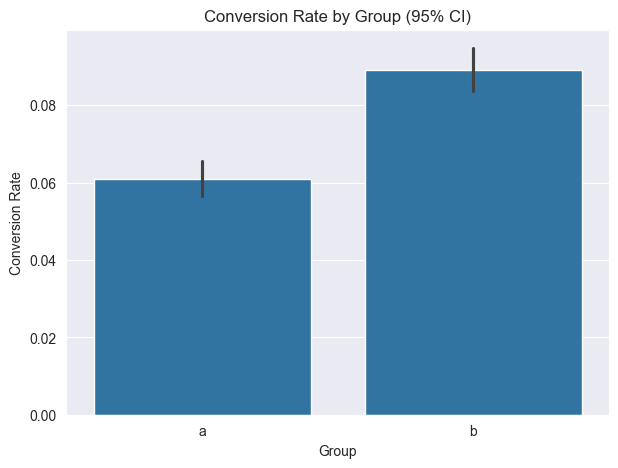

In [6]:
plt.figure(figsize=(7, 5))
sns.barplot(data=df, x="test_group", y="conversion", errorbar=("ci", 95))
plt.title("Conversion Rate by Group (95% CI)")
plt.xlabel("Group")
plt.ylabel("Conversion Rate")
plt.savefig("visuals/conversion_comparison.png", bbox_inches="tight")
plt.show()

## Conversion rate trend over time

We track daily conversion rate in each group to ensure the effect is stable over time.

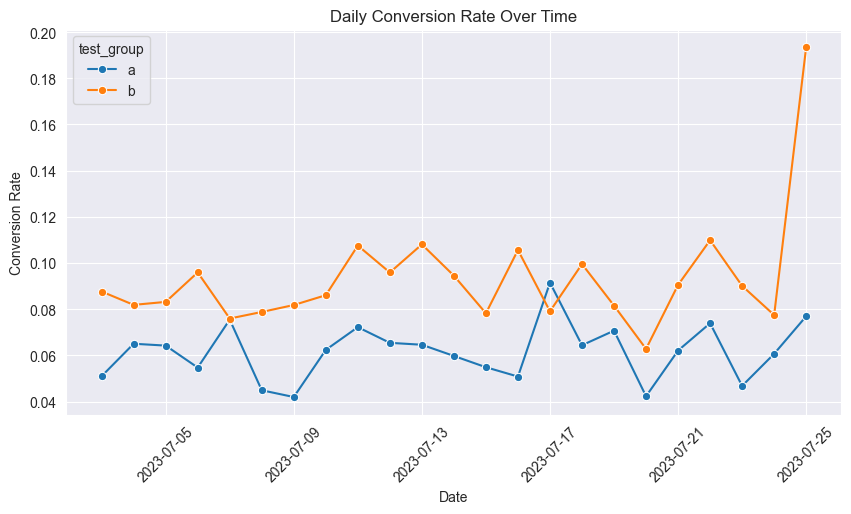

In [7]:
df["date"] = df["timestamp"].dt.date

daily = (
    df.groupby(["date", "test_group"])
      .agg(users=("user_id", "nunique"), conversions=("conversion", "sum"))
      .reset_index()
)

daily["cr"] = daily["conversions"] / daily["users"]
daily = daily.sort_values("date")

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily, x="date", y="cr", hue="test_group", marker="o")
plt.title("Daily Conversion Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.savefig("visuals/conversion_over_time.png", bbox_inches="tight")
plt.show()

## Conclusions and Product Recommendation

### Key results
- **CR(A)** = 6.10%
- **CR(B)** = 8.90%
- **Absolute uplift (B − A)** = +2.80 pp

### Statistical significance
We used a **two-proportion z-test** and obtained:
- p-value < 0.05 (α = 0.05)

✅ The uplift is statistically significant, so we **reject H0**.

### Product decision
Given the statistically significant improvement in purchase conversion rate,
**Variant B is recommended for rollout**, assuming no negative impact on guardrail metrics
(as stated in the task assumptions).

### Test period
- Start: 2023-07-03
- End: 2023-07-25
- Duration: 22 days